In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
              
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import pipeline



def preprocess_text(text):
    if pd.isnull(text):  # Check for NaN values
        return ""

    if not isinstance(text, str):  # Check for non-string values
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Tokenize the text into individual words
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word not in stop_words]

    # Join the words back into a single string
    processed_text = " ".join(filtered_words)

    return processed_text

# Read the CSV file
data = pd.read_csv('Musical_instruments_reviews.csv')

# Preprocess the text data
data['cleaned_text'] = data['reviewText'].apply(preprocess_text)
print(data['reviewText'].head(10))
# Print the cleaned text
#print(data['cleaned_text'])
# Print the first 10 rows of cleaned text
print(data['cleaned_text'].head(10))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    Not much to write about here, but it does exac...
1    The product does exactly as it should and is q...
2    The primary job of this device is to block the...
3    Nice windscreen protects my MXL mic and preven...
4    This pop filter is great. It looks and perform...
5    So good that I bought another one.  Love the h...
6    I have used monster cables for years, and with...
7    I now use this cable to run from the output of...
8    Perfect for my Epiphone Sheraton II.  Monster ...
9    Monster makes the best cables and a lifetime w...
Name: reviewText, dtype: object
0    much write exactly supposed filters pop sounds...
1    product exactly quite affordable realized doub...
2    primary job device block breath would otherwis...
3    nice windscreen protects mxl mic prevents pops...
4    pop filter great looks performs like studio fi...
5    good bought another one love heavy cord gold c...
6    used monster cables years good reason lifetime...
7    use cable run output pedal c

In [2]:
import gensim

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

#######


nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet

# Function for LDA topic analysis


def lda_topic_analysis(text_data, num_topics=5, num_top_words=10):
    # Make sure text_data is a list of documents
    if not isinstance(text_data, list):
        raise ValueError("text_data should be a list of documents.")

    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

    # Apply Latent Dirichlet Allocation (LDA) for topic modeling
    if not isinstance(num_topics, int):
        raise ValueError("num_topics should be an integer value.")
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_topics = lda_model.fit_transform(tfidf_matrix)

    # Get top N words for each topic
    feature_names = tfidf_vectorizer.get_feature_names_out()
    topic_titles = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[-num_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_titles.append(f"Topic {topic_idx+1}: {' '.join(top_words)}")

    return lda_topics, topic_titles, tfidf_vectorizer


[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\konst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def get_sentiment_score(word, pos):
    synsets = list(swn.senti_synsets(word, pos))
    if synsets:
        sentiment_score = (synsets[0].pos_score() - synsets[0].neg_score())
        return sentiment_score
    return 0.0  # If no sentiment score is found, return 0 as default

def get_pos_tag(word):
    # Map NLTK POS tags to WordNet POS tags
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if no mapping is found

def calculate_sentiment_score(text):
    sentiment_scores = []
    for word in text.split():
        pos = get_pos_tag(word)  # Get the WordNet POS tag
        sentiment_score = get_sentiment_score(word, pos)
        sentiment_scores.append(sentiment_score)

    if sentiment_scores:  # Check if sentiment_scores is not empty
        return sum(sentiment_scores) / len(sentiment_scores)  # Calculate average sentiment score

    return 0.0  # Return 0 as default if sentiment_scores is empty


data = pd.read_csv('Musical_instruments_reviews.csv')

data['cleaned_text'] = data['reviewText'].apply(preprocess_text)

# Calculate sentiment scores and assign sentiment labels
data['sentiment_score'] = data['cleaned_text'].apply(calculate_sentiment_score)
data['sentiment'] = data['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

# Extract the cleaned text and sentiment labels
text_data = data['cleaned_text'].tolist()
labels = data['sentiment'].tolist()


In [18]:
data = pd.read_csv('Musical_instruments_reviews.csv')

# Sample review number (replace with the desired review number)
review_number = 1

# Get the review text for the specified review number
review_text = data['reviewText'][review_number - 1]

# Generate topic labels using a text generation pipeline from Hugging Face Transformers
generator = pipeline("text-generation", model="gpt2")  # Use the "gpt2" model

# Find the maximum length of the input review text
max_review_length = len(review_text.split())

# Set the maximum length for the generated topic label to a value greater than the maximum review length
max_topic_length = max_review_length + 20  # Adding 20 tokens as buffer

print(f"Review {review_number}:")
print(review_text)

# Modify the prompt to provide only the review text without any other instructions
prompt = review_text

# Generate the topic label
generated = generator(prompt, max_length=max_topic_length, temperature=0.7, do_sample=True)
topic_label = generated[0]["generated_text"].replace(prompt, "").strip()

print(f"\nTopic Label for Review {review_number}: {topic_label}\n")






All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Review 1:
Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,

Topic Label for Review 1: the quality is pretty decent. if you want to try it



In [5]:
data = pd.read_csv('Musical_instruments_reviews.csv')

data['cleaned_text'] = data['reviewText'].apply(preprocess_text)

# Set the number of reviews
num_reviews_to_analyze = 15
review_texts = data['cleaned_text'][:num_reviews_to_analyze].tolist()


# Perform LDA Topic Analysis for each review
num_topics = 1  
num_top_words = 7
for i, review_text in enumerate(review_texts):
    lda_topics, topic_titles, _ = lda_topic_analysis([review_text], num_topics=num_topics, num_top_words=num_top_words)
    print(f"\nLDA Topic Analysis for Review {i+1}:")
    print(topic_titles[0])  # Display the first topic only (since we set num_topics=1)
    


LDA Topic Analysis for Review 1:
Topic 1: much filters pop might buy crisp despite

LDA Topic Analysis for Review 2:
Topic 1: even filter buy pop product work like

LDA Topic Analysis for Review 3:
Topic 1: voice would coloration job high goose frequencies

LDA Topic Analysis for Review 4:
Topic 1: windscreen thing avoid careful clamp gooseneck hold

LDA Topic Analysis for Review 5:
Topic 1: filter vocals studio sing recording recorded pops

LDA Topic Analysis for Review 6:
Topic 1: great works still bass bought carefully coil

LDA Topic Analysis for Review 7:
Topic 1: cables years lifetime break cost fact getting

LDA Topic Analysis for Review 8:
Topic 1: cable waves planet back pedal bought 00

LDA Topic Analysis for Review 9:
Topic 1: years well cables constructed degree epiphone got

LDA Topic Analysis for Review 10:
Topic 1: cables monster wrong hurt best cant doesnt

LDA Topic Analysis for Review 11:
Topic 1: model cables instrument higher looks expensive keyboards

LDA Topic An

# Sentiment Analysis

In [6]:
data = pd.read_csv('Musical_instruments_reviews.csv')

data['cleaned_text'] = data['reviewText'].apply(preprocess_text)

# Calculate sentiment scores and assign sentiment labels
data['sentiment_score'] = data['cleaned_text'].apply(calculate_sentiment_score)
data['sentiment'] = data['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

# Extract the cleaned text and sentiment labels
text_data = data['cleaned_text'].tolist()
labels = data['sentiment'].tolist()

sentiment_counts = data['sentiment'].value_counts()
print("\nUnique values and their counts for 'sentiment' column:")
print(sentiment_counts)


Unique values and their counts for 'sentiment' column:
positive    7914
negative    1926
neutral      421
Name: sentiment, dtype: int64


In [7]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

# Set the number of topics for LDA
num_topics = 5

# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

# Calculate perplexity
perplexity = lda_model.perplexity(tfidf_matrix)
print(f"LDA Perplexity: {perplexity}")

LDA Perplexity: 9292.028244304955


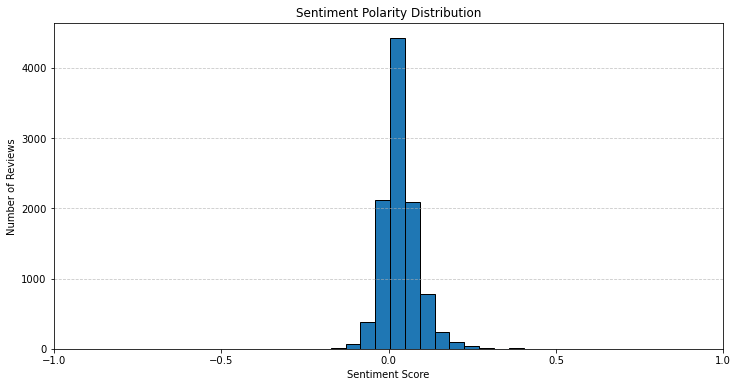

In [8]:
# Create a sentiment polarity distribution plot
plt.figure(figsize=(12, 6))
plt.hist(data['sentiment_score'], bins=20, edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Polarity Distribution')
plt.xticks([-1, -0.5, 0, 0.5, 1])  # Set custom x-axis ticks if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
data['word_count'] = data['reviewText'].apply(lambda x: len(str(x).split()))


In [10]:
data['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [11]:
def sentiment_n(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [12]:
#Applying the function in our new column
data['sentiment_n'] = data.apply(sentiment_n, axis=1)
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,cleaned_text,sentiment_score,sentiment,word_count,sentiment_n
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",much write exactly supposed filters pop sounds...,0.005435,positive,51,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",product exactly quite affordable realized doub...,0.066176,positive,104,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",primary job device block breath would otherwis...,0.023256,positive,77,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pops...,0.056250,positive,35,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",pop filter great looks performs like studio fi...,0.016667,positive,28,Positive


In [13]:
data['sentiment_n'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment_n, dtype: int64

This is Sentiment Distribution in the Dataset With lexicon-based approach using SentiWordNet

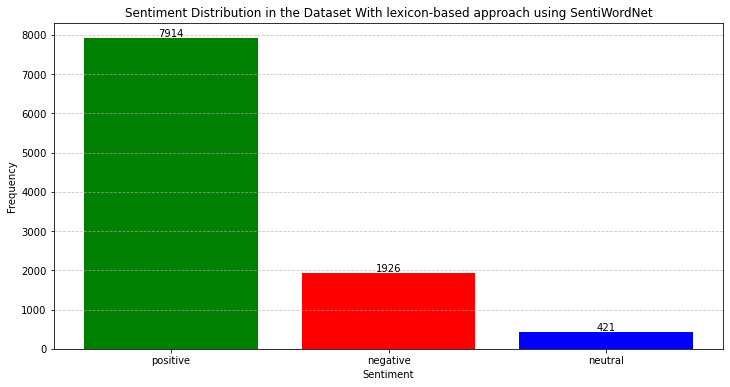

In [14]:
# Create a frequency bar chart for 'sentiment' column
sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution in the Dataset With lexicon-based approach using SentiWordNet')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.show()

This is Sentiment Distribution in the Dataset with Simple Rating Classification

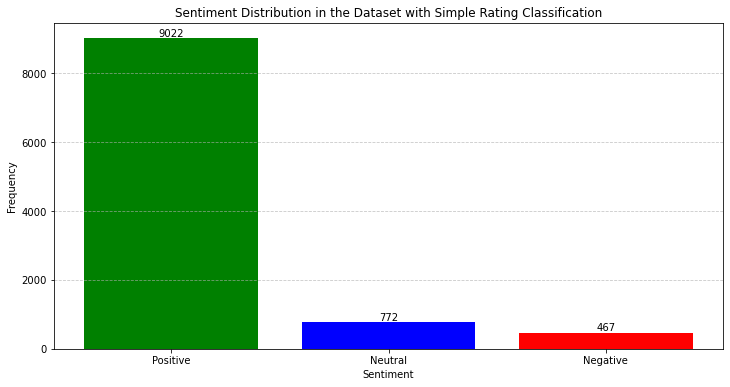

In [15]:
# Create a frequency bar chart for 'sentiment' column
sentiment_counts = data['sentiment_n'].value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution in the Dataset with Simple Rating Classification')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.show()

Finally a Review Text Word Count Distribution

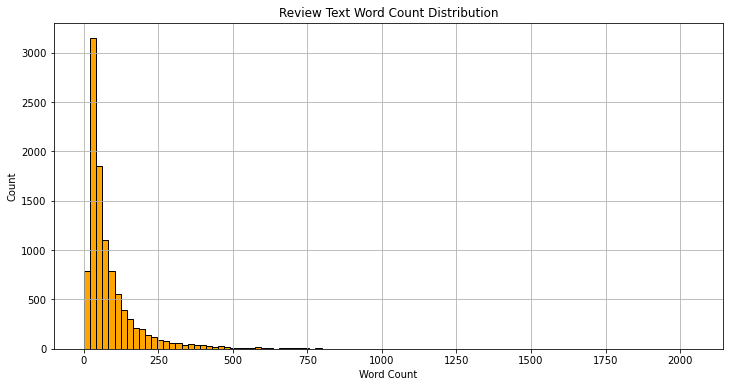

In [16]:
review_lengths = data['word_count']

plt.figure(figsize=(12, 6))  # Adjust the width and height as desired

plt.hist(review_lengths, bins=100, color='orange', edgecolor='black')

# Set the labels and title
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Review Text Word Count Distribution')


plt.grid(True)


plt.show()
